Imports

In [2]:
# Files, environment variables, etc.
from pathlib import Path
import os
from dotenv import load_dotenv
import random

import torch

# Dataset manipulation
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as tvutils
import numpy as np
import matplotlib.pyplot as plt

# Deep learning
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim



#cwd = Path.cwd()

#print(cwd)

#if not os.path.exists(str(cwd) + "/checkpoints"):
#    print('no')
#else:
#    print('yes')
#    os.mkdir(str(cwd) + "/checkpoints")

Paths

In [3]:
load_dotenv()

cwd = Path.cwd()

dataset_path = os.getenv("DATASET_PATH")
checkpoint_path = "/checkpoints"


Set the seed for reproducible results.

In [4]:
seed = 42
print("Random seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

Random seed:  42


GAN Settings

In [8]:
# Root directory for dataset.
dataroot = dataset_path

# Number of workers for dataloader.
workers = 2

# Batch size during training.
batch_size = 32 # Trying a smaller batch size; used to be 128.

# Spatial size of training images. All images will be resized to this size.
image_size = (256, 192) # (h, w)

# Number of channels in the training images. For color images this is 3.
nc = 3

# Size of z latent vector (i.e. size of generator input).
nz = 100

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
lr = 0.0002 # originally 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Load GPU.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Set to true to enable checkpointing.
enable_checkpoints = True

Verify PyTorch is using the GPU.

In [9]:
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

12.1
True
1


Load dataset.

Dataloader size:  411


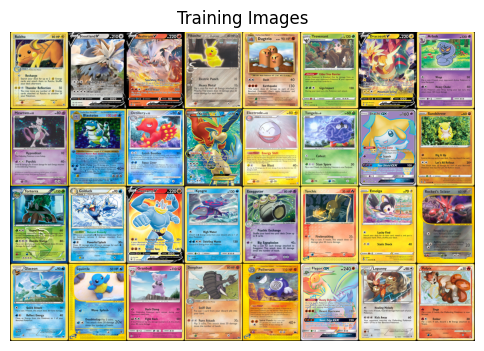

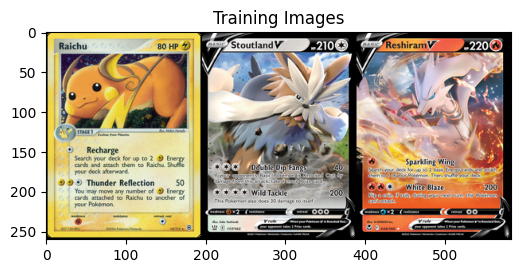

In [10]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

print("Dataloader size: ", len(dataloader))

# Plot some training images.
real_batch = next(iter(dataloader))
plt.figure(figsize=(6,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(tvutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

plt.figure(figsize=(6,3))
plt.title("Training Images")
plt.imshow(np.transpose(tvutils.make_grid(real_batch[0].to(device)[:3], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Note: I thought this code was pretty interesting.
#  .to(device) moves the tensor to the GPU.
#  [:64] chooses the first 64 images from the tensor.
#  tvutils.make_grid() arranges images in a grid.
#    padding=2 adds padding of 2 pixels between images
#    normalize=True scales the image pixel values between [0,1]
#  .cpu() moves the tensor back to the CPU, which is necessary because
#    matplotlib expects data to be on the CPU.
#  np.transpose() permutes the dimensions of the tensor.
#    (1, 2, 0) rearranges it from (channels, height, width) to (height, width, channels)
#    which is necessary because matplotlib expects image data to be in this form.
#  plt.imshow() displays the image data after the above transformations.

Weight Initialization

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Extra Modules

In [12]:
class GaussianNoise(nn.Module):
    # sigma: sigma*pixel value = stdev of added noise from normal distribution 
    def __init__(self, sigma=0.1):
        super().__init__()
        self.sigma = sigma
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.training and self.sigma != 0:
            # scale of noise = stdev of gaussian noise = sigma * pixel value 
            scale = self.sigma * x.detach()
            sampled_noise = self.noise.expand(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

In [13]:
class SpectralNorm(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = nn.utils.spectral_norm(module)
    def forward(self, x):
        return self.module(x)

Generator

In [40]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            # Input: 100 x 1

            nn.ConvTranspose2d(in_channels=nz, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            #  1024 x 4x4

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 512 x 8x8

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 256 x 16x16

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 128 x 32x32

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            # 64 x 64x64

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(4, 3), stride=(4, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            # 32 x 256x192

            nn.ConvTranspose2d(in_channels=16, out_channels=nc, kernel_size=1, stride=1, padding=0, bias=False), 
            nn.Tanh()

            # nc x 256x192

        )

    def forward(self, input):
        return self.main(input)

Instantiate Generator

In [41]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

print()

print(summary(netG, (1, nz, 1, 1)))

#print(summary(netG, (nz,)))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(

Discriminator

In [44]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            GaussianNoise(),

            # Input: nc x 256x192

            nn.Conv2d(in_channels=nc, out_channels=16, kernel_size=1, stride=1, padding=0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5), # Added

            # 32 x 256x192

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(4, 3), stride=(4, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5), # Added

            # 64 x 64x64

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False), # stride is 4 when modified
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5), # Added

            # 128 x 32x32

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.3), # Added

            # 256 x 16x16

            #nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(512),
            #nn.LeakyReLU(0.2, inplace=True),

            # 512 x 8x8

            #nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(1024),
            #nn.LeakyReLU(0.2, inplace=True),

            # 1024 x 4x4

            #nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            #nn.Sigmoid()

            # 1 x 4x4


            # Modifications
            #  \/

            #nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=4, padding=1, bias=False),
            #nn.BatchNorm2d(256),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.3), # Added

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.3), # Added

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # 256 x 4x4

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()

            # 1 x 4x4

        )

    def forward(self, input):
        return self.main(input)

Create Discriminator

In [45]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

print(summary(netD, (1, nc, image_size[0], image_size[1])))

Discriminator(
  (main): Sequential(
    (0): GaussianNoise()
    (1): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(4, 3), stride=(4, 3), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2, inplace=True)
    (15): Conv2d(128

Loss Functions and Optimizers

In [46]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Training Loop

In [47]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)): # iters changed from 500
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(tvutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/15][0/411]	Loss_D: 1.8834	Loss_G: 1.9504	D(x): 0.7813	D(G(z)): 0.7490 / 0.2106
[0/15][50/411]	Loss_D: 0.4642	Loss_G: 3.5264	D(x): 0.8369	D(G(z)): 0.1746 / 0.0710
[0/15][100/411]	Loss_D: 0.1245	Loss_G: 5.4459	D(x): 0.9562	D(G(z)): 0.0701 / 0.0076
[0/15][150/411]	Loss_D: 0.1648	Loss_G: 6.8771	D(x): 0.9016	D(G(z)): 0.0416 / 0.0023
[0/15][200/411]	Loss_D: 0.1393	Loss_G: 5.7611	D(x): 0.9744	D(G(z)): 0.0981 / 0.0072
[0/15][250/411]	Loss_D: 0.2475	Loss_G: 4.9758	D(x): 0.9025	D(G(z)): 0.0173 / 0.0109
[0/15][300/411]	Loss_D: 0.0314	Loss_G: 6.1435	D(x): 0.9861	D(G(z)): 0.0166 / 0.0039
[0/15][350/411]	Loss_D: 0.0234	Loss_G: 6.1291	D(x): 0.9891	D(G(z)): 0.0122 / 0.0058
[0/15][400/411]	Loss_D: 0.0150	Loss_G: 6.8385	D(x): 0.9939	D(G(z)): 0.0085 / 0.0022
[1/15][0/411]	Loss_D: 0.5090	Loss_G: 9.9087	D(x): 0.8374	D(G(z)): 0.0131 / 0.0070
[1/15][50/411]	Loss_D: 0.2411	Loss_G: 3.4315	D(x): 0.8260	D(G(z)): 0.0002 / 0.0605
[1/15][100/411]	Loss_D: 0.0592	Loss_G: 5.8729	D(x): 0.97

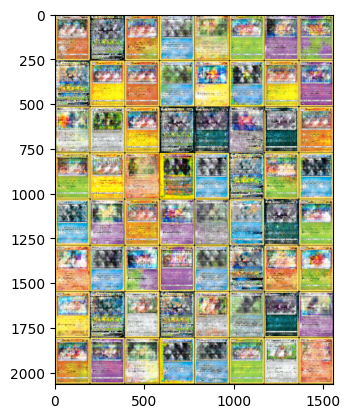

In [66]:
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

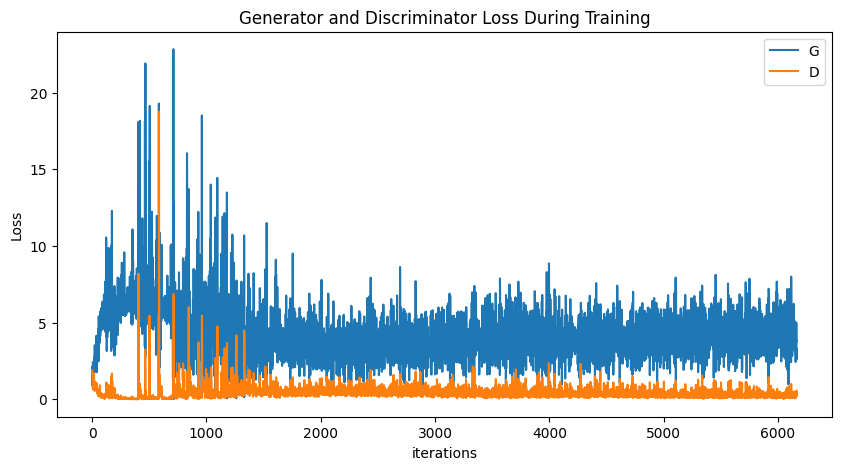

In [67]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Generate a single example.

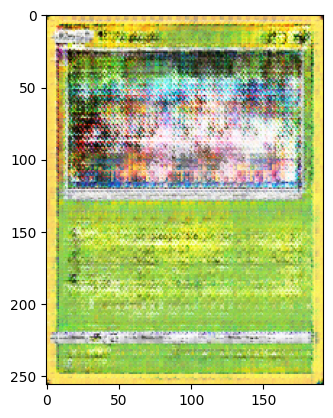

In [73]:
# Generate a single latent vector
single_noise = torch.randn(1, nz, 1, 1, device=device)

# Generate a single image using the trained generator
netG.eval()  # Set the generator to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    generated_image = netG(single_noise).detach().cpu()

# Assuming the generated image tensor is in the shape [1, 3, 256, 192]
generated_image = generated_image.squeeze(0)  # Remove the batch dimension
generated_image = (generated_image + 1) / 2  # Denormalize to the range [0, 1]

# Convert the tensor to a numpy array
generated_image_np = generated_image.permute(1, 2, 0).numpy()  # Change the shape to [256, 192, 3]

# Display the image using matplotlib
plt.imshow(generated_image_np)
#plt.axis('off')  # Turn off the axis
plt.show()

Save the model.

In [75]:
torch.save(netG.state_dict(), "models/model6-25-0.pt")

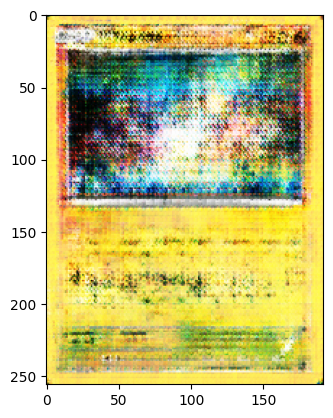

In [77]:
"""
# test it

model_test = Generator(ngpu)

model_test.load_state_dict(torch.load("models/model6-25-0.pt"))


# Generate a single latent vector
single_noise = torch.randn(1, nz, 1, 1, device=device)

# Generate a single image using the trained generator
model_test.eval()  # Set the generator to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    generated_image = netG(single_noise).detach().cpu()

# Assuming the generated image tensor is in the shape [1, 3, 256, 192]
generated_image = generated_image.squeeze(0)  # Remove the batch dimension
generated_image = (generated_image + 1) / 2  # Denormalize to the range [0, 1]

# Convert the tensor to a numpy array
generated_image_np = generated_image.permute(1, 2, 0).numpy()  # Change the shape to [256, 192, 3]

# Display the image using matplotlib
plt.imshow(generated_image_np)
#plt.axis('off')  # Turn off the axis
plt.show()

"""

In [79]:
  # Save checkpoint info
torch.save({
      'epoch': epoch,
      'gen_state_dict': netG.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'disc_state_dict': netD.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'img_list': img_list,
      'G_losses': G_losses,
      'D_losses': D_losses,
  }, 'models/model6-25-0-checkpoint.pt')